---
## **Clustering-Based Spectrum Sensing with OFDM Modulation for Cognitive Radio Networks**
---

### Importing Libraries

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc
import cmath

### Setting Parameters

In [107]:
# 1. OFDM and Modulation Parameters
N = 64                # Number of subcarriers
cp_len = 16           # Cyclic prefix length
num_symbols = 100     # Number of OFDM symbols
snr_db = 10           # SNR in dB
window_size = 128     # Samples per window for sensing
step_size = 64        # Window step size

### 📺 **FFT and IFFT Algorithm Explanation**

*For a clear visual and conceptual explanation of the FFT and IFFT algorithms, you can refer to this helpful video:*

[![FFT and IFFT Algorithm](http://img.youtube.com/vi/h7apO7q16V0/0.jpg)](https://www.youtube.com/watch?v=h7apO7q16V0)

### FFT implemetation from scratch

In [108]:
def FFT(P):
    n = len(P)  
    if n == 1:
        return P

    omega = cmath.exp(2j * cmath.pi / n)

    P_e = P[0::2]  
    P_o = P[1::2]  

    y_e = FFT(P_e)
    y_o = FFT(P_o)

    y = [0] * n
    for j in range(n // 2):
        omega_j = omega**j
        y[j] = y_e[j] + omega_j * y_o[j]
        y[j + n // 2] = y_e[j] - omega_j * y_o[j]

    return y

### IFFT implemetation from scratch

In [109]:
def IFFT(P):
    n = len(P)
    if n == 1:
        return P

    omega_inv = cmath.exp(-2j * cmath.pi / n)

    P_e = P[0::2]
    P_o = P[1::2]

    y_e = IFFT(P_e)
    y_o = IFFT(P_o)

    y = [0] * n
    for j in range(n // 2):
        omega_j = omega_inv ** j
        y[j] = y_e[j] + omega_j * y_o[j]
        y[j + n // 2] = y_e[j] - omega_j * y_o[j]

    # Scale the result by 1/n
    return [val / n for val in y]

### **OFDM modulator and demodulator using IFFT and FFT**

### 🧠 OFDM System Overview

The following diagram illustrates the basic **transmitter and receiver architecture** of an **OFDM system**:

![OFDM Diagram](ofdm.png)

> 📚 **Reference:** [Transmitter and Receiver architecture of OFDM (ResearchGate)](https://www.researchgate.net/figure/Transmitter-and-Receiver-architecture-of-OFDM_fig2_325283793)


In [110]:
# 2. BPSK Modulation/Demodulation
def bpsk_mod(bits): return 2 * bits - 1
def bpsk_demod(symbols): return (symbols.real > 0).astype(int)

# 3. OFDM Modulation
def ofdm_modulate(bits):
    symbols = bpsk_mod(bits).reshape((num_symbols, N))
    ifft_data = np.array([IFFT(row) for row in symbols])  # IFFT per row
    cp = ifft_data[:, -cp_len:]                           # Take last cp_len as prefix
    tx_signal = np.hstack((cp, ifft_data))                # Add prefix
    return tx_signal.flatten() 

def ofdm_demodulate(rx_signal):
    blocks = rx_signal.reshape((num_symbols, N + cp_len)) 
    no_cp = blocks[:, cp_len:]
    fft_data = np.array([FFT(row) for row in no_cp])
    return fft_data.reshape(-1)


### AWGN noise addition to signal

In [111]:
# 5. Add AWGN Noise
def awgn(signal, snr_db):
    snr_linear = 10 ** (snr_db / 10)
    power = np.mean(np.abs(signal)**2)
    noise_power = power / snr_linear
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    return signal + noise

### Energy over a window

In [112]:

# 6. Energy Detection over Sliding Windows
def sliding_window_energy(signal, win_len, step):
    energies, windows = [], []
    for i in range(0, len(signal) - win_len + 1, step):
        w = signal[i:i+win_len]
        energies.append(np.sum(np.abs(w)**2))
        windows.append(w)
    return np.array(energies), np.array(windows)


### **K-means clustering method**
- We can also use thresholding method but to find perfect threshold may require computation.
- If we will proceed by thresholding then to draw ROC we can directly get by changing threshold and calculating TPR (True Positive Rate) and FPR (False Positive Rate).

In [113]:
# 7. KMeans Clustering
def cluster_energy(energies):
    km = KMeans(n_clusters=2, random_state=0).fit(energies.reshape(-1, 1))
    labels = km.labels_
    means = [np.mean(energies[labels == i]) for i in range(2)]
    signal_cluster = np.argmax(means)
    detections = (labels == signal_cluster)
    return detections, labels, means

### ROC computation

In [114]:
# 8. ROC Curve Analysis
def compute_roc(energies, true_labels):
    fpr, tpr, thresholds = roc_curve(true_labels, energies)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

### Simulation of signal over modulation, noise and demodulation

In [115]:
# 9. Main Simulation
np.random.seed(42)
bits = np.random.randint(0, 2, N * num_symbols)
tx_signal = ofdm_modulate(bits)

# Channel with AWGN
rx_signal = awgn(tx_signal, snr_db)

# True label generation: windows that overlap with transmitted signal are marked 1
true_labels = []
for i in range(0, len(rx_signal) - window_size + 1, step_size):
    window_start = i
    window_end = i + window_size
    if window_end < len(tx_signal):
        true_labels.append(1)  # Contains signal
    else:
        true_labels.append(0)  # Outside transmission
true_labels = np.array(true_labels)

# Energy Detection & Clustering
energies, windows = sliding_window_energy(rx_signal, window_size, step_size)
detections, labels, cluster_means = cluster_energy(energies)

# Bit Error Rate (optional decoding)
rx_symbols = ofdm_demodulate(rx_signal)
rx_bits = bpsk_demod(rx_symbols)
ber = np.sum(bits != rx_bits) / len(bits)

### Signal Plots

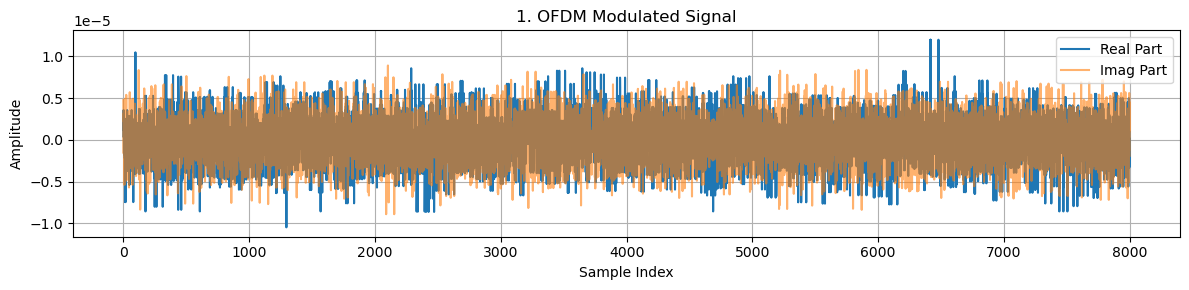

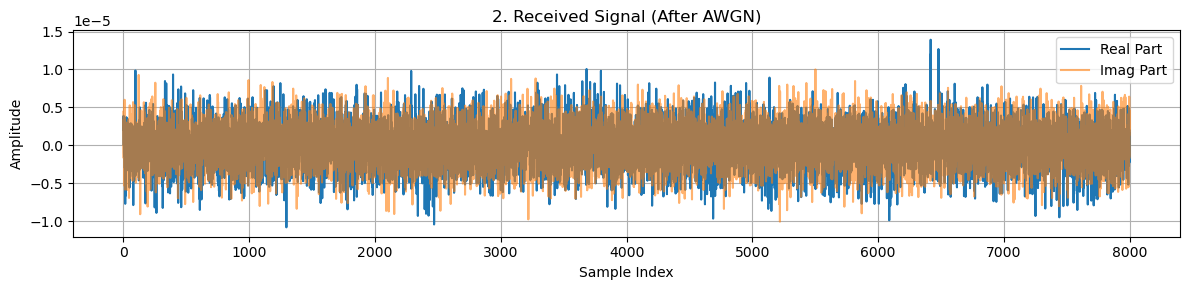

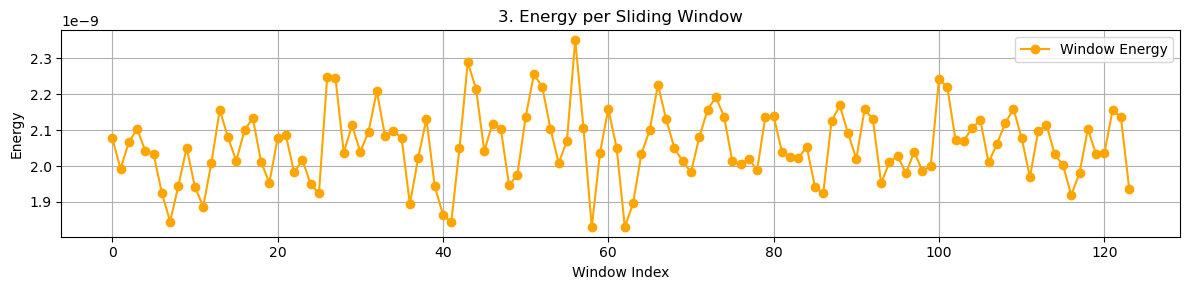

In [116]:
# 1. Plot OFDM modulated signal
plt.figure(figsize=(12, 3))
plt.plot(np.real(tx_signal), label='Real Part')
plt.plot(np.imag(tx_signal), label='Imag Part', alpha=0.6)
plt.title("1. OFDM Modulated Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Plot received signal (after AWGN)
plt.figure(figsize=(12, 3))
plt.plot(np.real(rx_signal), label='Real Part')
plt.plot(np.imag(rx_signal), label='Imag Part', alpha=0.6)
plt.title("2. Received Signal (After AWGN)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Plot sliding window energy
plt.figure(figsize=(12, 3))
plt.plot(energies, marker='o', color='orange', label='Window Energy')
plt.title("3. Energy per Sliding Window")
plt.xlabel("Window Index")
plt.ylabel("Energy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Energy & Clusters Plot

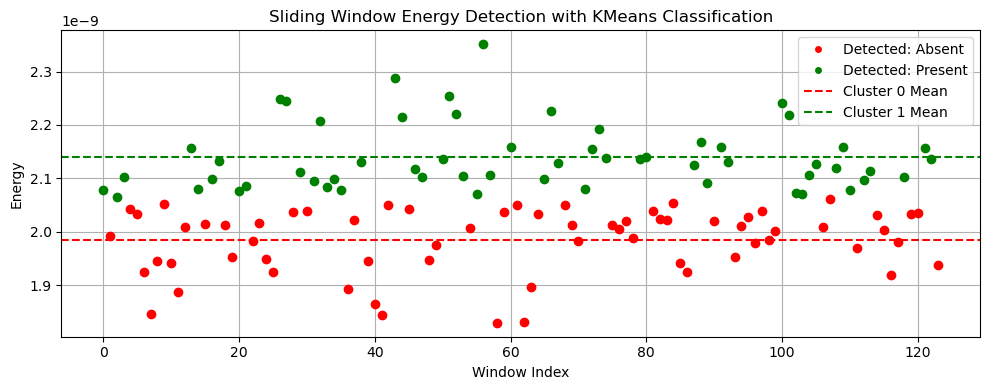

In [117]:
plt.figure(figsize=(10, 4))

# Color code by cluster label
for i in range(len(energies)):
    label = labels[i]
    color = 'green' if label == 1 else 'red'
    plt.plot(i, energies[i], marker='o', color=color)

# Optional: Plot cluster means as dotted lines
plt.axhline(y=cluster_means[0], linestyle='--', color='r', label=f"Cluster 0 Mean = {cluster_means[0]:.2f}")
plt.axhline(y=cluster_means[1], linestyle='--', color='g', label=f"Cluster 1 Mean = {cluster_means[1]:.2f}")

plt.title("Sliding Window Energy Detection with KMeans Classification")
plt.xlabel("Window Index")
plt.ylabel("Energy")
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Detected: Absent'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='Detected: Present'),
    plt.Line2D([0], [0], color='r', linestyle='--', label='Cluster 0 Mean'),
    plt.Line2D([0], [0], color='g', linestyle='--', label='Cluster 1 Mean')
]
plt.legend(handles=legend_elements)
plt.grid(True)
plt.tight_layout()
plt.show()


### ROC curve plot

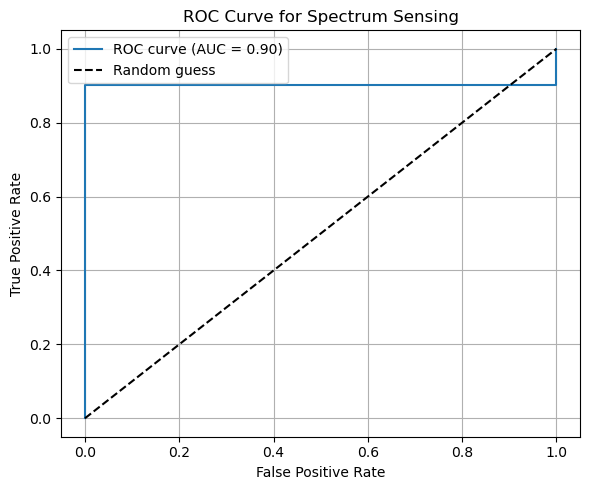

In [118]:
fpr, tpr, roc_auc = compute_roc(energies, true_labels)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Spectrum Sensing')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Results

In [119]:
print(f"Detected {np.sum(detections)} of {len(detections)} windows as signal-present.")
print(f"Bit Error Rate (BER): {ber:.4f}")

Detected 58 of 124 windows as signal-present.
Bit Error Rate (BER): 0.0000


> We can see that our BER is approximately zero.